In [38]:
%matplotlib inline

import datetime
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import time

In [39]:
##helper methods
def simple_rmse(model, X, Y):
    y_pred = model.predict(X)
    rmse = -np.sqrt(mean_squared_error(y_pred, Y))
    return rmse

def rmse_cv(model, X_train, y):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def plot_it(model):
    model.fit(train_split, train_split_labels)
    preds = model.predict(dev)
    
    deltas = preds-dev_labels
    print "mean: %3.4f" %np.mean(deltas)
    print "standard deviation: %3.4f" %np.std(deltas)
    
    plt.scatter(dev_labels,preds)
    plt.xlim((10,14.0))
    plt.ylim((10,14.0))
    plt.plot(range(10,15), range(10,15));
    
def plot_pca(model, n):
    scores = []
    pca = PCA(n)
    pca_train = pca.fit_transform(train_split)
    pca_dev = pca.transform(dev)
    for i in range(n):
        model.fit(pca_train[:,0:i+1], train_split_labels)
        scores.append(-simple_rmse(model, pca_dev[:,0:i+1], dev_labels))
    
    plt.scatter(range(1,n+1),scores)
    plt.show()

In [40]:
# ##read in data
train = pd.read_csv('data/train_fe.csv',delimiter=',',header=0)
train_labels = train["SalePrice"].copy()
train_labels = np.log(train["SalePrice"])
train = train.drop( ["SalePrice"], axis=1 )
train = train.drop(['Unnamed: 0'],axis=1)
train_split, dev, train_split_labels, dev_labels = train_test_split(train,train_labels, test_size = .5, random_state=207)

train_preds = pd.read_csv('data/linear_out.csv',delimiter=',',header=0)
train_preds["Actual"] = np.log(train_preds["Actual"])
preds_labels = train_preds["Actual"].copy()
train_preds = train_preds.drop(['Actual'],axis=1)
train_preds = train_preds.drop(['Unnamed: 0'],axis=1)

test = pd.read_csv('data/train_fe.csv',delimiter=',',header=0)
test = test.drop(['Unnamed: 0'],axis=1)
# test_preds = pd.read_csv()


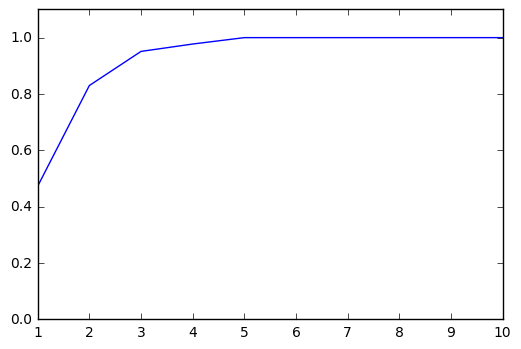

In [47]:
##pca
pca_test = PCA(10)
pca_x = pca_test.fit_transform(dev)
#pca_x2 = pca_test.fit_transform(test)

var = []
for a in range(10):
    var.append(np.sum(pca_test.explained_variance_ratio_[:a+1]))
    
plt.plot(range(1,11), var)
plt.ylim((0,1.1));

In [50]:
# ##combine pca and predictions
# pca_x = pd.DataFrame(pca_x)
# comb = pd.concat([train_preds, pca_x], axis=1)
# print comb.shape

(730, 14)


20.0279998779
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=2,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.153833984269
{'max_features': 'auto', 'loss': 'ls', 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 2}
[-0.38803907 -0.38696683 -0.38590223 -0.38484707 -0.38379807 -0.38275091
 -0.38171104 -0.38651654 -0.38506666 -0.38362396 -0.38218743 -0.38076025
 -0.37934392 -0.37793679 -0.38605757 -0.3844919  -0.38293559 -0.38138837
 -0.37985054 -0.37832185 -0.37680238 -0.35336211 -0.34495642 -0.33700688
 -0.32953481 -0.32247558 -0.31580644 -0.30945421 -0.33960635 -0.32825507
 -0.31749917 -0.30738766 -0.29776924 -0.28866887 -0.28010145 -0.33509937
 

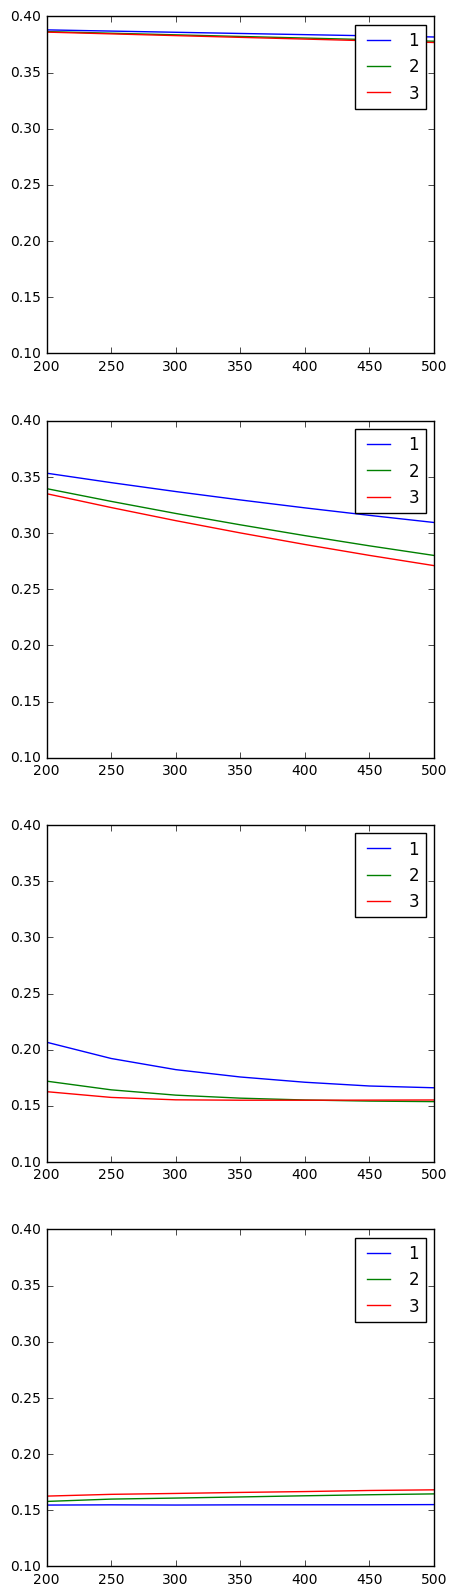

In [45]:
##build ensemble model
ensemble = GBR()
##GradientBoostingRegressor
est = [200,250,300,350,400, 450, 500]
md = [1,2,3]
lr = [.0001,.001,.01, .1]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["ls"]}#,"ls", "lad", "huber"]}
gs3 = GridSearchCV(ensemble, gbr_params, scoring = simple_rmse)
gs3.fit(train_preds,preds_labels)
end = time.time()
print end-start
print gs3.best_estimator_
print gs3.best_score_
print gs3.best_params_
print gs3.cv_results_['mean_test_score']

f, axarr = plt.subplots(len(lr))
for b,val2 in enumerate(lr):
    for a,val in enumerate(md):
        axarr[b].plot(est,-gs3.cv_results_['mean_test_score'][(len(est)*a)+(len(est)*len(md))*b:(len(est)*(a+1))+(len(est)*len(md))*b], label=val)
        axarr[b].legend()
        axarr[b].set_ylim((.1,.4))
        
f.set_figheight(5 * len(lr))
f.set_figwidth(5)
f.show;

In [ ]:
##best version
ls_gbr_best = GBR(n_estimators =gs3.best_params_['n_estimators'],max_features =gs3.best_params_['max_features'], max_depth =gs3.best_params_['max_depth'], learning_rate =gs3.best_params_['learning_rate'], loss=gs3.best_params_['loss'])
plot_it(ls_gbr_best)

In [ ]:
##output results
preds = pd.DataFrame(np.exp(ls_gbr_best.predict(test)))
preds.to_csv('data/final_preds.csv',index=False)